<a href="https://colab.research.google.com/github/yijing22/RL-CFR/blob/master/cnn_ratio_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to generate synthetic bar charts, train a CNN-based regressor (VGG or ResNet as a frozen feature extractor + MLP), and evaluate it on a ratio estimation task (predicting the ratio min(h, H)/max(h, H) for a marked bar pair).

**Contents**
1. Setup & environment check  
2. Synthetic chart generators (5 types)  
3. Quick visual sanity check  
4. Dataset generation (train / val / test)  
5. Feature extractor (VGG/ResNet) + MLP regressor  
6. Training  
7. Evaluation & plots  
8. Single-example inference demo
9. Exhaustive test

## 1. Setup & environment check

In [ ]:
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import skimage.draw

import tensorflow as tf
import keras

# Check GPU availability
physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) == 0:
    print("No GPU found! Check your runtime configuration in Runtime -> Change runtime type.")
else:
    print("GPUs:", physical_devices)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Synthetic chart generators

We define five bar-chart types that draw either grouped bars or stacked bars.  
Each function receives a pair of heights (two integers) and returns a 100x100 boolean image where True denotes chart strokes (bars/marks). Markers indicate the target pair whose ratio we want to predict.

In [ ]:
def data_to_type1(data: list[int]) -> np.ndarray:
    # Type 1: Many grouped bars; the target pair is at indices 1 and 2.
    barchart = np.zeros((100, 100), dtype=bool)

    all_values = np.random.randint(5, 86, size=10)
    all_values[1] = data[0] - 1
    all_values[2] = data[1] - 1

    start = 0
    gap = 2
    b_width = 7

    for i, d in enumerate(all_values):
        if i == 0:
            start += 2
        elif i == 5:
            start += 8

        left_bar = start + i*gap + i*b_width
        right_bar = left_bar + b_width

        rr, cc = skimage.draw.line(99, left_bar, 99-int(d), left_bar)
        barchart[rr, cc] = True
        rr, cc = skimage.draw.line(99, right_bar, 99-int(d), right_bar)
        barchart[rr, cc] = True
        rr, cc = skimage.draw.line(99-int(d), left_bar, 99-int(d), right_bar)
        barchart[rr, cc] = True

        if i == 1 or i == 2: # add two dots
            barchart[97:98, left_bar + b_width//2 : left_bar + b_width//2 + 1] = True

    return barchart


def data_to_type2(data: list[int]) -> np.ndarray:
    # Type 2: Two stacked bars. The first segment of each encodes data[0] and data[1], respectively.
    barchart = np.zeros((100, 100), dtype=bool)

    # Left stack
    all_values = [0] * 8
    all_values[0] = data[0] - 1
    current_max = 98 - all_values[0]
    all_values[1] = np.random.randint(3, current_max//3 + 1)
    all_values[2] = np.random.randint(3, current_max//3 + 1)
    all_values[3] = np.random.randint(3, current_max//3 + 1)

    current_max = int(np.sum(all_values[0:4]))
    rr, cc = skimage.draw.line(99, 10, 99-int(current_max), 10)
    barchart[rr, cc] = True
    rr, cc = skimage.draw.line(99, 40, 99-int(current_max), 40)
    barchart[rr, cc] = True

    current = 0
    for i, d in enumerate(all_values[:4]):
        rr, cc = skimage.draw.line(99 - (int(d)+current), 10, 99 - (int(d)+current), 40)
        barchart[rr, cc] = True
        current += int(d)
        if i == 0:
            barchart[99 - int(d)//2 : 99 - int(d)//2 + 1, 25:26] = True

    # Right stack
    all_values[4] = data[1] - 1
    current_max = 98 - all_values[4]
    all_values[5] = np.random.randint(3, current_max//3 + 1)
    all_values[6] = np.random.randint(3, current_max//3 + 1)
    all_values[7] = np.random.randint(3, current_max//3 + 1)

    current_max = int(np.sum(all_values[4:]))
    rr, cc = skimage.draw.line(99, 60, 99-int(current_max), 60)
    barchart[rr, cc] = True
    rr, cc = skimage.draw.line(99, 90, 99-int(current_max), 90)
    barchart[rr, cc] = True

    current = 0
    for i, d in enumerate(all_values[4:]):
        rr, cc = skimage.draw.line(99 - (int(d)+current), 60, 99 - (int(d)+current), 90)
        barchart[rr, cc] = True
        current += int(d)
        if i == 0:
            barchart[99 - int(d)//2 : 99 - int(d)//2 + 1, 75:76] = True

    return barchart


def data_to_type3(data: list[int]) -> np.ndarray:
    # Type 3: Grouped bars; target bars at indices 1 and 6.
    barchart = np.zeros((100, 100), dtype=bool)

    all_values = [0] * 10
    all_values[0] = np.random.randint(5, 86)
    all_values[1] = data[0] - 1
    all_values[2] = np.random.randint(5, 86)
    all_values[3] = np.random.randint(5, 86)
    all_values[4] = np.random.randint(5, 86)
    all_values[5] = np.random.randint(5, 86)
    all_values[6] = data[1] - 1
    all_values[7] = np.random.randint(5, 86)
    all_values[8] = np.random.randint(5, 86)
    all_values[9] = np.random.randint(5, 86)

    start = 0
    gap = 2
    b_width = 7

    for i, d in enumerate(all_values):
        if i == 0:
            start += 2
        elif i == 5:
            start += 8

        left_bar = start + i*gap + i*b_width
        right_bar = left_bar + b_width

        rr, cc = skimage.draw.line(99, left_bar, 99-int(d), left_bar)
        barchart[rr, cc] = True
        rr, cc = skimage.draw.line(99, right_bar, 99-int(d), right_bar)
        barchart[rr, cc] = True
        rr, cc = skimage.draw.line(99-int(d), left_bar, 99-int(d), right_bar)
        barchart[rr, cc] = True

        if i == 1 or i == 6:
            barchart[97:98, left_bar + b_width//2 : left_bar + b_width//2 + 1] = True

    return barchart


def data_to_type4(data: list[int]) -> np.ndarray:
    # Type 4: Two stacked bars; the top segment in each stack corresponds to data[0] and data[1].
    barchart = np.zeros((100, 100), dtype=bool)
    all_values = [0] * 8

    # Left stack
    current_max = 98 - (data[0] - 1)
    all_values[0] = np.random.randint(3, current_max//3 + 1)
    all_values[1] = np.random.randint(3, current_max//3 + 1)
    all_values[2] = np.random.randint(3, current_max//3 + 1)
    below_last_sum = int(np.sum(all_values[0:3]))
    all_values[3] = data[0] - 1
    current_max = int(np.sum(all_values[0:4]))
    above_last_sum = current_max

    rr, cc = skimage.draw.line(99, 10, 99-int(current_max), 10)
    barchart[rr, cc] = True
    rr, cc = skimage.draw.line(99, 40, 99-int(current_max), 40)
    barchart[rr, cc] = True

    current = 0
    for i, d in enumerate(all_values[:4]):
        rr, cc = skimage.draw.line(99 - (int(d)+current), 10, 99 - (int(d)+current), 40)
        barchart[rr, cc] = True
        current += int(d)
        if i == 3:
            barchart[99-current + (int(d)//2) : 99-current + (int(d)//2) + 1, 25:26] = True

    # Right stack: ensure sums differ from left
    below_last_sum2 = below_last_sum
    above_last_sum2 = above_last_sum
    ctr = 0
    while below_last_sum2 == below_last_sum or above_last_sum2 == above_last_sum:
        if ctr == 20:
            break
        current_max = 98 - (data[1] - 1)
        all_values[4] = np.random.randint(3, current_max//3 + 1)
        all_values[5] = np.random.randint(3, current_max//3 + 1)
        all_values[6] = np.random.randint(3, current_max//3 + 1)
        below_last_sum2 = int(np.sum(all_values[4:8]))
        all_values[7] = data[1] - 1
        current_max = int(np.sum(all_values[4:]))
        above_last_sum2 = current_max
        ctr += 1

    rr, cc = skimage.draw.line(99, 60, 99-int(current_max), 60)
    barchart[rr, cc] = True
    rr, cc = skimage.draw.line(99, 90, 99-int(current_max), 90)
    barchart[rr, cc] = True

    current = 0
    for i, d in enumerate(all_values[4:]):
        rr, cc = skimage.draw.line(99 - (int(d)+current), 60, 99 - (int(d)+current), 90)
        barchart[rr, cc] = True
        current += int(d)
        if i == 3:
            barchart[99-current + (int(d)//2) : 99-current + (int(d)//2) + 1, 75:76] = True

    return barchart


def data_to_type5(data: list[int]) -> np.ndarray:
    # Type 5: Left is a two-segment stacked bar for the target pair; right is a filler stack.
    barchart = np.zeros((100, 100), dtype=bool)
    all_values = [0] * 8

    current_max = 98 - (data[0] - 1) - (data[1] - 1)
    if current_max <= 6:
        raise ValueError("Out of bounds for Type 5 composition.")

    # Left stack (contains both target heights)
    all_values[0] = np.random.randint(3, current_max//2 + 1)
    all_values[1] = np.random.randint(3, current_max//2 + 1)
    all_values[2] = data[0] - 1
    all_values[3] = data[1] - 1

    current_max = int(np.sum(all_values[0:4]))
    rr, cc = skimage.draw.line(99, 10, 99-int(current_max), 10)
    barchart[rr, cc] = True
    rr, cc = skimage.draw.line(99, 40, 99-int(current_max), 40)
    barchart[rr, cc] = True

    current = 0
    for i, d in enumerate(all_values[:4]):
        rr, cc = skimage.draw.line(99 - (int(d)+current), 10, 99 - (int(d)+current), 40)
        barchart[rr, cc] = True
        current += int(d)
        if i in (2, 3):
            barchart[99-current + (int(d)//2) : 99-current + (int(d)//2) + 1, 25:26] = True

    # Right stack: filler up to < 98
    while True:
        all_values[4] = np.random.randint(3, 98//3 + 1)
        all_values[5] = np.random.randint(3, 98//3 + 1)
        all_values[6] = np.random.randint(3, 98//3 + 1)
        all_values[7] = np.random.randint(3, 98//3 + 1)
        current_max = int(np.sum(all_values[4:]))
        if current_max <= 97:
            break

    rr, cc = skimage.draw.line(99, 60, 99-int(current_max), 60)
    barchart[rr, cc] = True
    rr, cc = skimage.draw.line(99, 90, 99-int(current_max), 90)
    barchart[rr, cc] = True

    current = 0
    for d in all_values[4:]:
        rr, cc = skimage.draw.line(99 - (int(d)+current), 60, 99 - (int(d)+current), 90)
        barchart[rr, cc] = True
        current += int(d)

    return barchart


data_to_type = {
    1: data_to_type1,
    2: data_to_type2,
    3: data_to_type3,
    4: data_to_type4,
    5: data_to_type5,
}


## 3. Quick visual sanity check

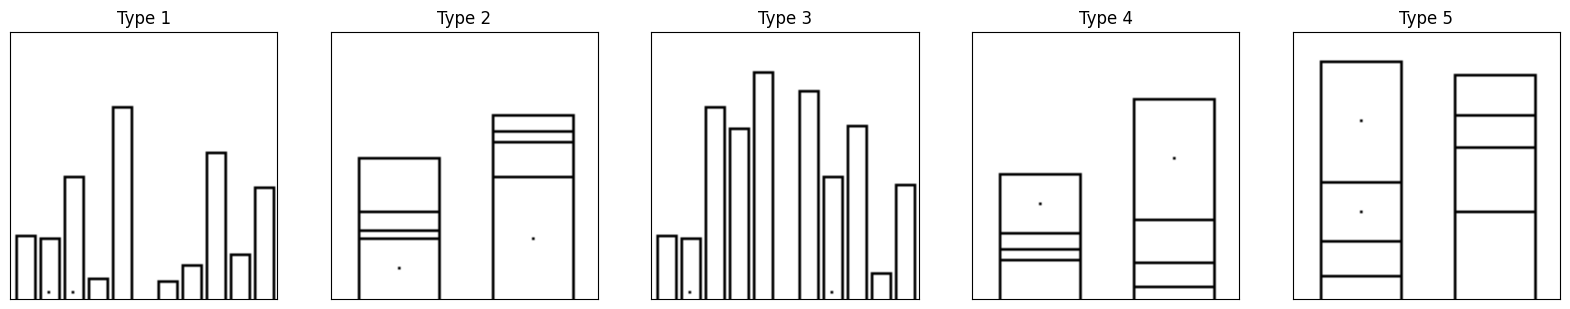

In [ ]:
# Visualize an example pair across all 5 types
data_example = [23, 46]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(1, 6):
    img = data_to_type[i](data_example)
    axes[i-1].imshow(img, cmap='gray_r')
    axes[i-1].set_title(f'Type {i}')
    axes[i-1].set_xticks([])
    axes[i-1].set_yticks([])
plt.show()

## 4. Dataset generation

In [ ]:
# All valid (h, H) with 5 <= h < H <= 85
height_pairs = [[h, H] for H in range(6, 86) for h in range(5, H)]

# All valid (h, H) with 5 <= h < H <= 85 and h + H <= 90 (Type 5 constraint)
height_pairs_type5 = [[h, H] for H in range(6, 86) for h in range(5, H) if h + H <= 90]

def random_data(type5: bool=False) -> list[int]:
    # Sample a random pair and shuffle order (so model cannot exploit position)
    base = height_pairs_type5 if type5 else height_pairs
    pair = random.choice(base)
    random.shuffle(pair)
    return pair

BARTYPE = 2              # 1..5
IMG_SIZE = 100
CHANNELS = 3

train_target = 600
val_target   = 200
test_target  = 200

X_train = np.zeros((train_target, IMG_SIZE, IMG_SIZE), dtype=np.float32)
y_train = np.zeros((train_target, 1), dtype=np.float32)
X_val   = np.zeros((val_target,   IMG_SIZE, IMG_SIZE), dtype=np.float32)
y_val   = np.zeros((val_target,   1), dtype=np.float32)
X_test  = np.zeros((test_target,  IMG_SIZE, IMG_SIZE), dtype=np.float32)
y_test  = np.zeros((test_target,  1), dtype=np.float32)

train_data = np.zeros((train_target, 2), dtype=np.float32)
val_data   = np.zeros((val_target,   2), dtype=np.float32)
test_data  = np.zeros((test_target,  2), dtype=np.float32)

t0 = time.time()

for i in range(train_target):
    pair  = random_data(BARTYPE == 5)
    label = min(pair) / max(pair)
    image = data_to_type[BARTYPE](pair)

    train_data[i] = pair
    y_train[i]    = label
    X_train[i]    = image

for i in range(val_target):
    pair  = random_data(BARTYPE == 5)
    label = min(pair) / max(pair)
    image = data_to_type[BARTYPE](pair)

    val_data[i] = pair
    y_val[i]    = label
    X_val[i]    = image

for i in range(test_target):
    pair  = random_data(BARTYPE == 5)
    label = min(pair) / max(pair)
    image = data_to_type[BARTYPE](pair)

    test_data[i] = pair
    y_test[i]    = label
    X_test[i]    = image

X_train_rgb = np.stack((X_train,) * CHANNELS, axis=-1)
X_val_rgb   = np.stack((X_val,)   * CHANNELS, axis=-1)
X_test_rgb  = np.stack((X_test,)  * CHANNELS, axis=-1)

print("Data generation time:", round(time.time() - t0, 2), "sec")
print("Train shape:", X_train_rgb.shape, "Targets:", y_train.shape)

Data generation time: 0.23 sec
Train shape: (600, 100, 100, 3) Targets: (600, 1)


## 5. Feature extractor (VGG/ResNet) + MLP regressor

In [ ]:
MODEL = 'VGG'  # 'VGG' | 'ResNet' | 'MLP'

if MODEL == "VGG":
    feature_extrator = keras.applications.VGG16(
        include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)
    )
    inputs = feature_extrator.input
    features = feature_extrator.output

elif MODEL == "ResNet":
    feature_extrator = keras.applications.ResNet50(
        include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)
    )
    inputs = feature_extrator.input
    features = feature_extrator.output

elif MODEL == "MLP":
    # Use raw images directly
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
    features = keras.layers.Flatten()(inputs)

else:
    raise ValueError("Unimplemented MODEL. Choose 'VGG', 'ResNet', or 'MLP'.")

# ===== MLP head =====
MLP = keras.models.Sequential([
    # keras.layers.Flatten(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1, activation="linear")
])

# ===== Final model =====
if MODEL in ("VGG", "ResNet"):
    model = keras.Model(inputs=inputs, outputs=MLP(features))
else:
    model = keras.Model(inputs=inputs, outputs=MLP(inputs))

# ===== Compile =====
adam = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="mean_squared_error", optimizer=adam, metrics=["mse", "mae"])
print(model.summary())
if MODEL in ("VGG", "ResNet"):
    print(MLP.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │       131,585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 14,846,273 (56.63 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,585 (514.00 KB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

None


## 6. Training

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
]

t0 = time.time()
history = model.fit(
    X_train_rgb, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_rgb, y_val),
    callbacks=callbacks,
    verbose=True,
)
fit_time = time.time() - t0
print(f"Fitting time: {fit_time:.2f}s")

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.2602 - mae: 0.4318 - mse: 0.2602 - val_loss: 0.1141 - val_mae: 0.2748 - val_mse: 0.1141
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0896 - mae: 0.2495 - mse: 0.0896 - val_loss: 0.0833 - val_mae: 0.2362 - val_mse: 0.0833
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0761 - mae: 0.2341 - mse: 0.0761 - val_loss: 0.0793 - val_mae: 0.2313 - val_mse: 0.0793
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0760 - mae: 0.2340 - mse: 0.0760 - val_loss: 0.0680 - val_mae: 0.2183 - val_mse: 0.0680
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0660 - mae: 0.2199 - mse: 0.0660 - val_loss: 0.0637 - val_mae: 0.2126 - val_mse: 0.0637
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0669 - mae: 0.2205 - mse: 0.0669 - val_loss: 0.0597 - val_mae: 0.2081 - val_mse: 0.0597
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0653 - mae: 0.2197 - mse: 0.0653 - val_

In [ ]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

## 7. Evaluation & plots

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step
Test MAE: 0.01985117
Test MSE: 0.0013486965


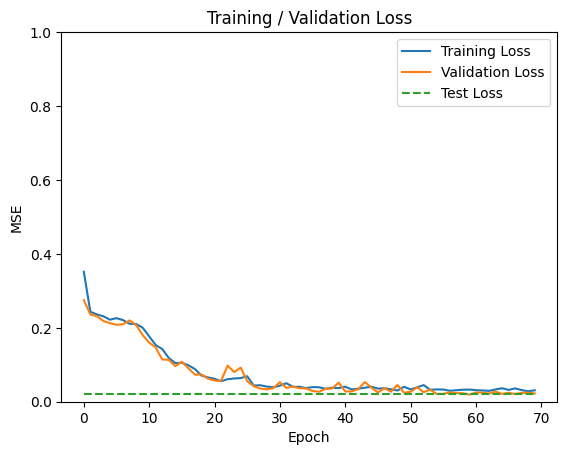

In [ ]:
y_pred = model.predict(X_test_rgb)

test_mae = np.mean(np.abs(y_pred - y_test))
test_mse = np.mean((y_pred - y_test) ** 2)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)

plt.figure()
plt.plot(history.history["mae"], label="Training Loss")
plt.plot(history.history["val_mae"], label="Validation Loss")
plt.plot([test_mae] * len(history.history["mae"]), "--", label="Test Loss")
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training / Validation Loss")
plt.show()

## 8. Single-example inference demo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


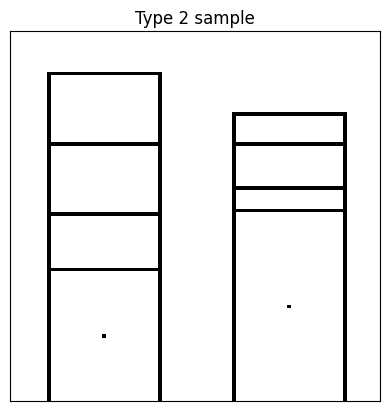

Height pair: [36, 52]
True ratio: 0.692
Predicted ratio: 0.678


In [ ]:
pair = random_data(BARTYPE == 5)
ratio = round(min(pair) / max(pair), 3)
img = data_to_type[BARTYPE](pair).astype(float)
img_rgb = np.stack((img,) * 3, axis=-1)

pred = float(model.predict(np.expand_dims(img_rgb, 0))[0][0])

plt.imshow(img, cmap="gray_r")
plt.xticks([])
plt.yticks([])
plt.title(f"Type {BARTYPE} sample")
plt.show()

print("Height pair:", pair)
print("True ratio:", ratio)
print("Predicted ratio:", round(pred, 3))

# 9. Exhaustive Test

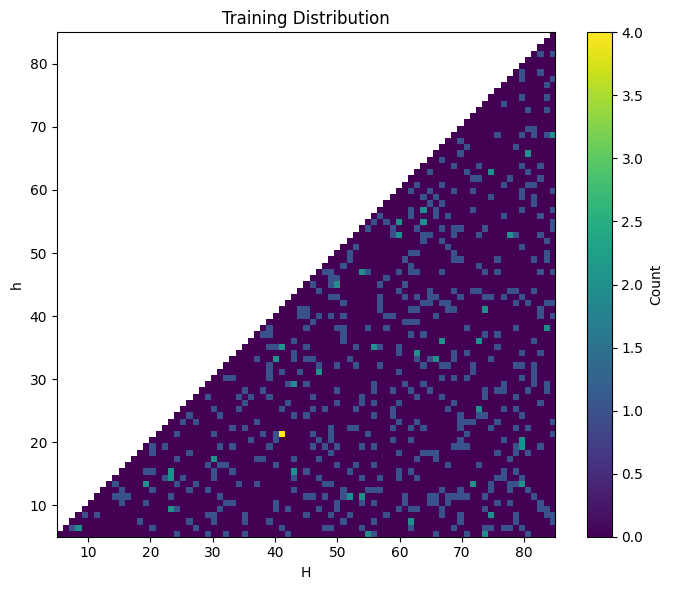

Generated 9720 images for 3240 pairs.
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 521ms/step


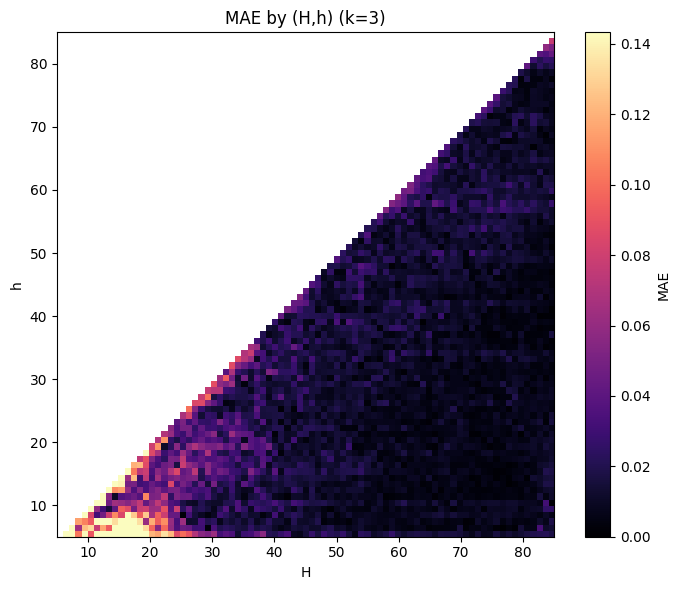

In [ ]:
def make_pairs() -> list[tuple[int, int]]:
    """Return valid (h,H) pairs depending on BARTYPE."""
    pairs = []
    for H in range(6, 86):
        for h in range(5, H):
            if BARTYPE == 5 and h + H > 90:
                continue
            pairs.append((h, H))
    return pairs

def to_grid(pairs: np.ndarray) -> np.ndarray:
    """Map (h,H) pairs to 81×81 count grid."""
    grid = np.zeros((81, 81), np.float32)
    h = np.minimum(pairs[:, 0], pairs[:, 1]).astype(int)
    H = np.maximum(pairs[:, 0], pairs[:, 1]).astype(int)
    valid = (h >= 5) & (H <= 85) & (h < H)
    if BARTYPE == 5:
        valid &= (h + H <= 90)
    h, H = h[valid], H[valid]
    np.add.at(grid, (h - 5, H - 5), 1)
    return grid

def show_heatmap(mat, title, label, cmap="viridis", vmin=None, vmax=None):
    """Plot heatmap with H on X, h on Y."""
    mask = np.tri(81, 81, -1, dtype=bool)  # mask h>=H
    data = np.ma.array(mat, mask=mask | np.isnan(mat))
    plt.figure(figsize=(7, 6))
    im = plt.imshow(data, origin="lower", extent=[5, 85, 5, 85],
                    cmap=cmap, aspect="auto", vmin=vmin, vmax=vmax)
    plt.colorbar(im, label=label)
    plt.xlabel("H"); plt.ylabel("h"); plt.title(title)
    plt.tight_layout(); plt.show()

# ===== 1. Distribution heatmaps =====
train_grid = to_grid(train_data)
show_heatmap(train_grid, "Training Distribution", "Count")

# ===== 2. Generate exhaustive test set =====
K = 3  # images per (H,h) to take average
pairs = make_pairs()
X_all, y_true, pair_idx = [], [], []

for idx, (h, H) in enumerate(pairs):
    ratio = h / H
    for _ in range(K):
        data = [h, H]
        random.shuffle(data)
        img = data_to_type[BARTYPE](data).astype(np.float32)
        X_all.append(np.stack((img,)*3, -1))
        y_true.append(ratio)
        pair_idx.append(idx)

X_all = np.stack(X_all)
y_true = np.array(y_true, np.float32)
pair_idx = np.array(pair_idx, np.int32)

print(f"Generated {len(X_all)} images for {len(pairs)} pairs.")

# ===== 3. Batch predict =====
y_pred = model.predict(X_all, batch_size=512, verbose=1).reshape(-1)
mae = np.abs(y_pred - y_true)

# ===== 4. Aggregate MAE by (h,H) =====
pair_mae = np.zeros(len(pairs), np.float32)
for i in range(len(pairs)):
    m = pair_idx == i
    pair_mae[i] = mae[m].mean()

err_grid = np.full((81, 81), np.nan, np.float32)
for (h, H), e in zip(pairs, pair_mae):
    err_grid[h - 5, H - 5] = e

vmax = np.percentile(err_grid[~np.isnan(err_grid)], 99)
show_heatmap(err_grid, f"MAE by (H,h) (k={K})", "MAE", cmap="magma", vmin=0, vmax=vmax)
